In [1]:
from data_pipeline.np_dataset import NpDataset
import input_mapping.models_torch as models_torch
from data_pipeline.image_transforms import get_transforms

from data_pipeline.data_package import DataPackage





from PIL import Image
from pydicom import dcmread
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import numpy as np

from ai_backend.loggers.model_logger import is_min
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam
import torch
import json
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recall
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd



/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home

In [2]:
#checkpoint 1
augmentations = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(p=0.6),
                transforms.RandomVerticalFlip(p=0.5)
            ])

In [3]:
#create np datasets for training, validation and testing
read_dicom = lambda x: dcmread(x).pixel_array
dicom_file_reader = lambda x: Image.fromarray(read_dicom(x)).convert('RGB')
default_file_reader = lambda x: Image.open(x).convert('RGB')


In [4]:
model_id = '05aac62e-b966-49cc-a2e8-0d4a03a8dc53'
model_key = 'resnet18'
model_folder = f'models/{model_key}/{model_id}'
path_to_model_conig = f'{model_folder}/run_config.json'
#load the model configuration
with open(path_to_model_conig, 'r') as f:
    run_config = json.load(f)
#also

In [5]:
transform_type = run_config['transform_type']
transforms_config = models_torch.model_dict[model_key]['transforms_config']
transform = get_transforms(transform_name = transform_type, transforms_config = transforms_config)

In [6]:
#train the model
dataset_name = '2024-06-05_16-22-01'
#load the dataset configuration
path_to_dataset_config = f'datasets/{dataset_name}/dataset_config.json'

with open(path_to_dataset_config, 'r') as f:
    dataset_config = json.load(f)
#get the the labels
labels_to_encode = dataset_config['labels_to_encode']


In [7]:
best_model_save_folder = f'models/{model_key}/{model_id}'
best_model_save_path = f'{best_model_save_folder}/weights.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
def convert_package_to_dataset(package, augmentations=None):
    file_reader = dicom_file_reader if package.data_source_name == 'UKB' else default_file_reader
    dataset = NpDataset(file_paths=package.get_data(), labels=package.get_labels(),
                         file_reader=file_reader, transform=transform, augmentation_transform=augmentations)
    return dataset

def convert_package_list_to_dataset(package_list, augmentations=None):
    datasets = []
    for package in package_list:
        dataset = convert_package_to_dataset(package)
        datasets.append(dataset)
    return datasets

In [9]:
#list the saved directories and load the datapackages
dataset_path = 'datasets/2024-06-05_16-22-01'
train_packages_path = f'{dataset_path}/train'
val_packages_path = f'{dataset_path}/val'
test_packages_path = f'{dataset_path}/test'
package_paths = [train_packages_path, val_packages_path, test_packages_path]
train_packages = []
val_packages = []
test_packages = []
all_packages = [train_packages, val_packages, test_packages]

for path, package_list  in zip(package_paths, all_packages):
    files = os.listdir(path)
    for file in files:
        package = DataPackage.load(f'{path}/{file}')
        package_list.append(package)
#convert to np datasets
train_datasets = convert_package_list_to_dataset(train_packages, augmentations=augmentations)
val_datasets = convert_package_list_to_dataset(val_packages)
test_datasets = convert_package_list_to_dataset(test_packages)


In [10]:
#concat the datasets
train_dataset = ConcatDataset(train_datasets)
validation_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

#create data loaders
num_workers = 96
batch_size = 2
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [11]:
# create model
model = models_torch.get_model(model_name=model_key, num_classes=len(labels_to_encode))


/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [13]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

In [14]:
evaluations_save_folder = f'{best_model_save_folder}/evaluations'
os.makedirs(evaluations_save_folder, exist_ok=True)

In [15]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

In [16]:
#sread the best thresholds
with open(f'{best_model_save_folder}/best_thresholds.json', 'r') as f:
    best_thresholds = json.load(f)
#convert to tensor
best_thresholds = torch.tensor(best_thresholds, dtype=torch.float32)


In [17]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

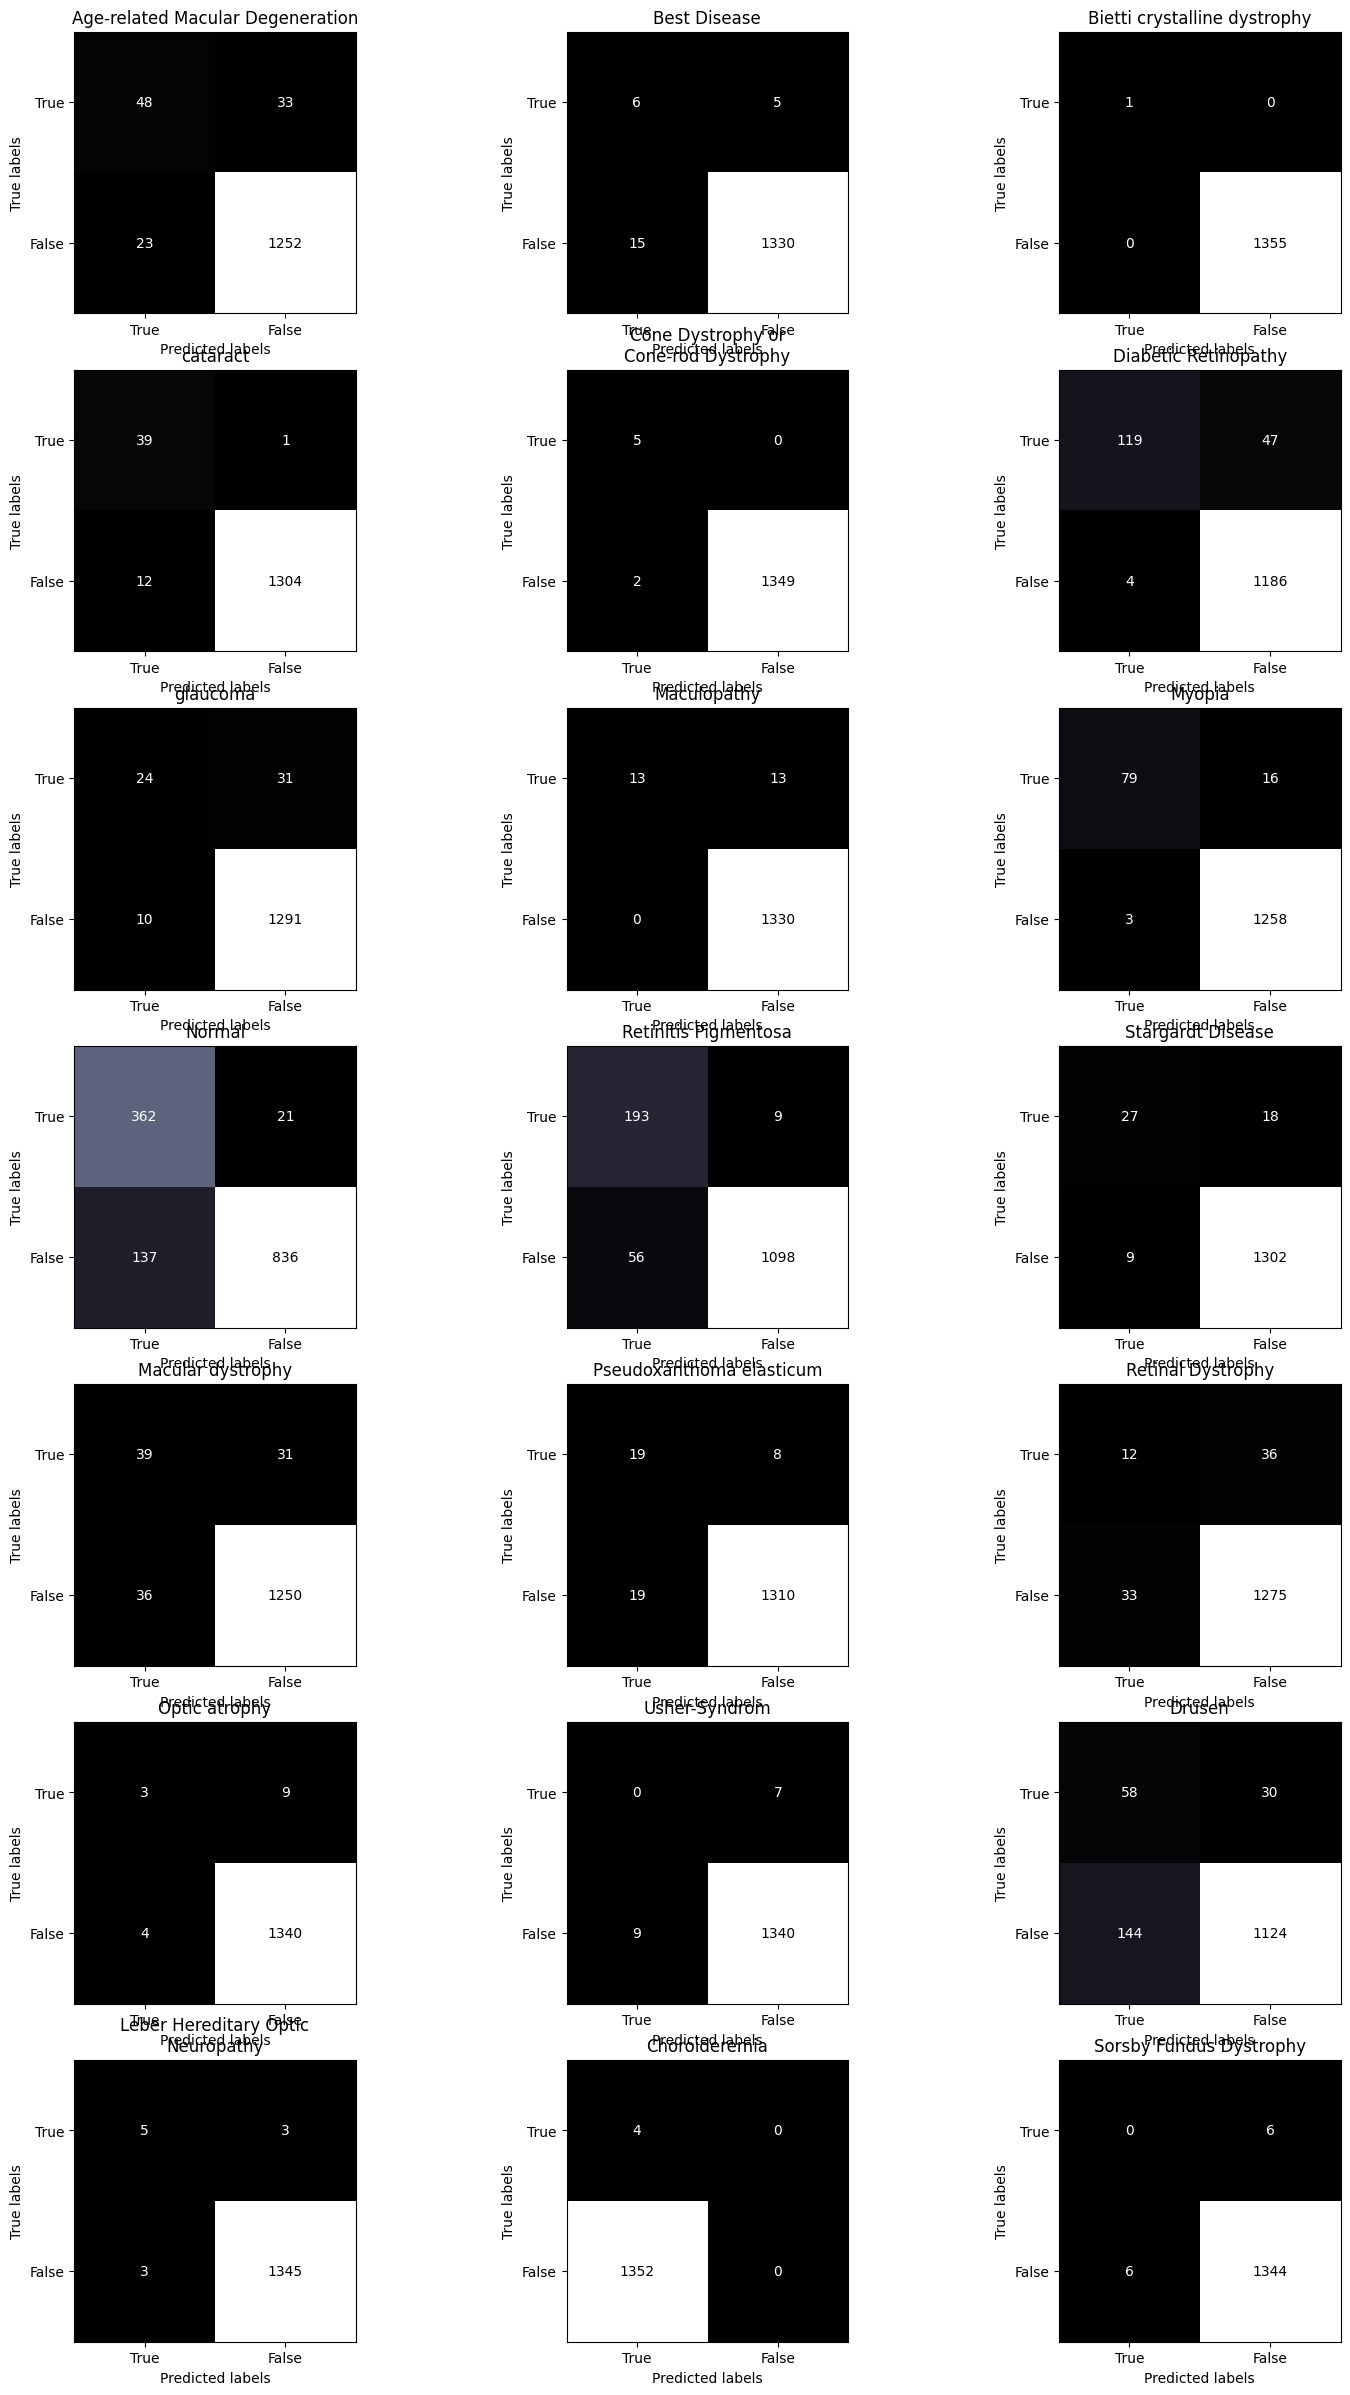

In [18]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(labels_to_encode) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 36))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
#save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices.png')

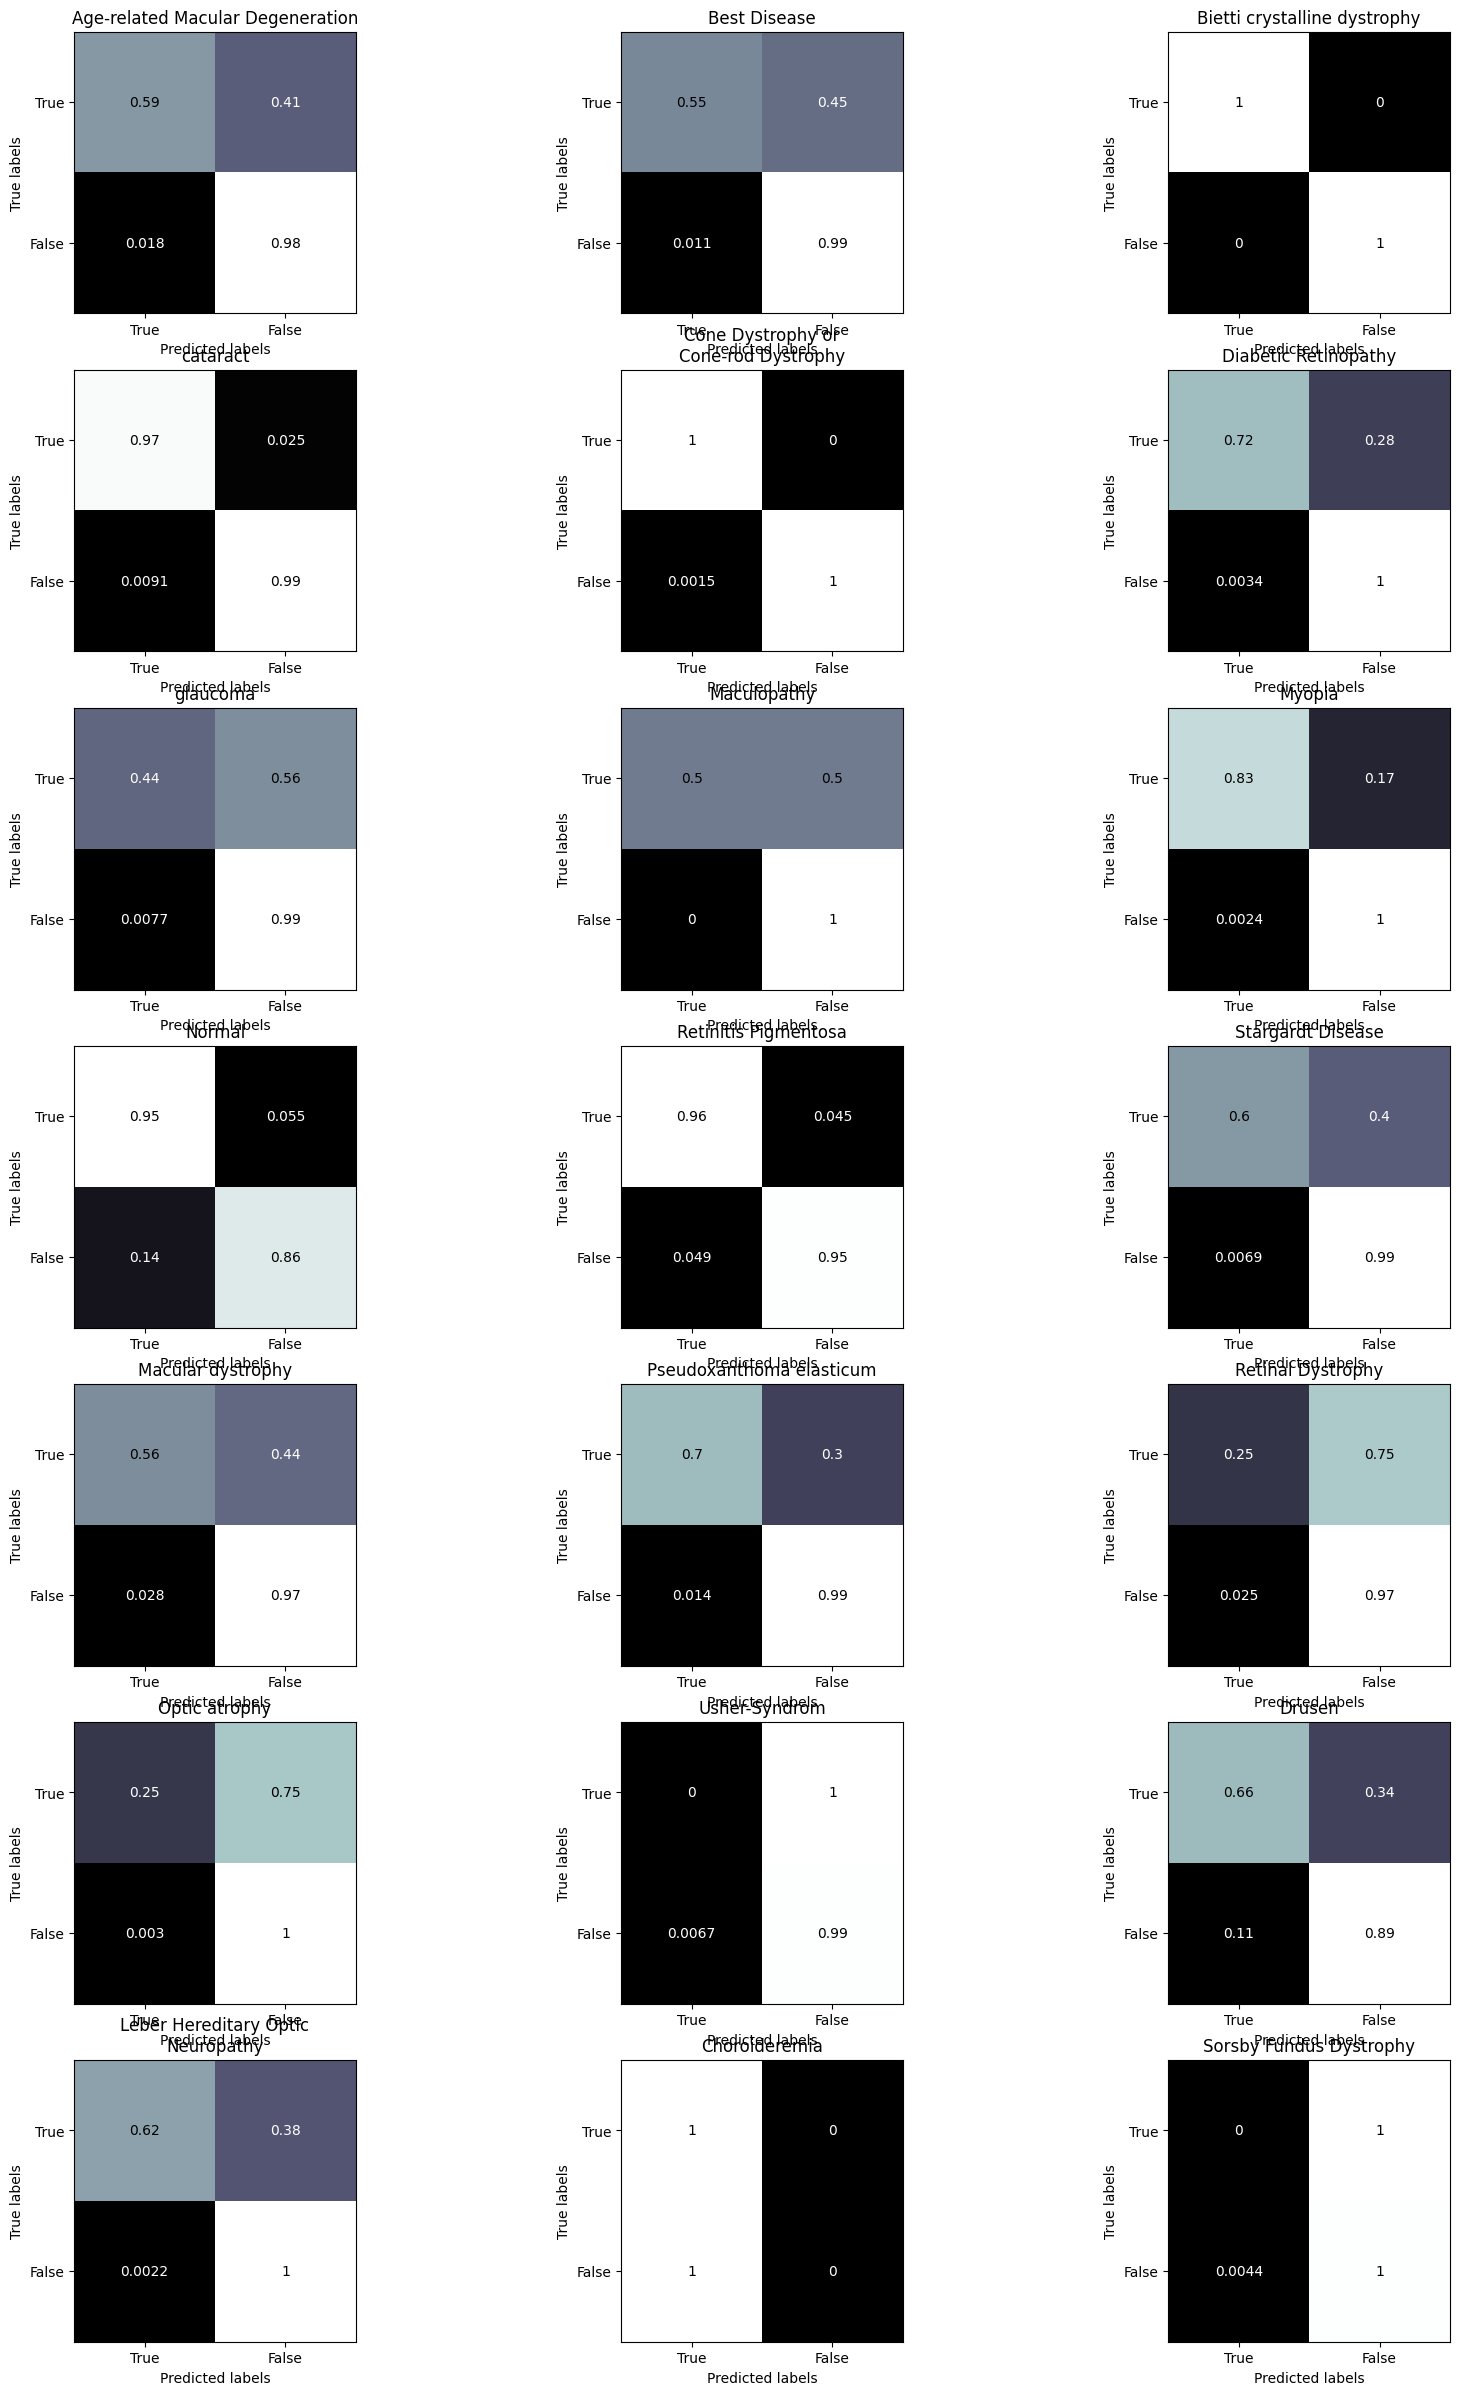

In [19]:
#plot the same confusion matrices with the row normalised values
cm_normalizer = confusion_matrices.sum(axis=2)#[:,np.newaxis]
#add a new dimension to the normalizer
cm_normalizer = cm_normalizer[:,np.newaxis]
#add a copy of the normalizer to the normalizer

#cm_normalizer = np.concatenate([cm_normalizer, cm_normalizer], axis=0)
reversed_normalizer = np.flip(cm_normalizer, axis=-1)
cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
#flip the normalizer
cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
normalized_cms = confusion_matrices / cm_normalizer
flipped_normalised_cms = np.flip(np.flip(normalized_cms, axis=-1), axis=-2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 36))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_normalised_cms[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    #save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices_normalized.png')

In [20]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision_macro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall_macro = multi_label_recall(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy_macro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1_macro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
#do the same for the micro scores
precision_micro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall_micro = multi_label_recall(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy_micro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1_micro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)

#save the evaluation metrics in a dictionary
evaluation_metrics = {
    'precision_macro': precision_macro,
    'recall_macro': recall_macro,
    'accuracy_macro': accuracy_macro,
    'f1_macro': f1_macro,
    'precision_micro': precision_micro,
    'recall_micro': recall_micro,
    'accuracy_micro': accuracy_micro,
    'f1_micro': f1_micro
}
#save the evaluation metrics
with open(f'{evaluations_save_folder}/evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f)

TP: 1056
FP: 1877
TN: 25219
FN: 324
-----------------------------------


In [21]:
#print the evaluation metrics
for key, value in evaluation_metrics.items():
    print(key,':', round(value,2))

precision_macro : 0.57
recall_macro : 0.63
accuracy_macro : 0.92
f1_macro : 0.6
precision_micro : 0.36
recall_micro : 0.77
accuracy_micro : 0.92
f1_micro : 0.49


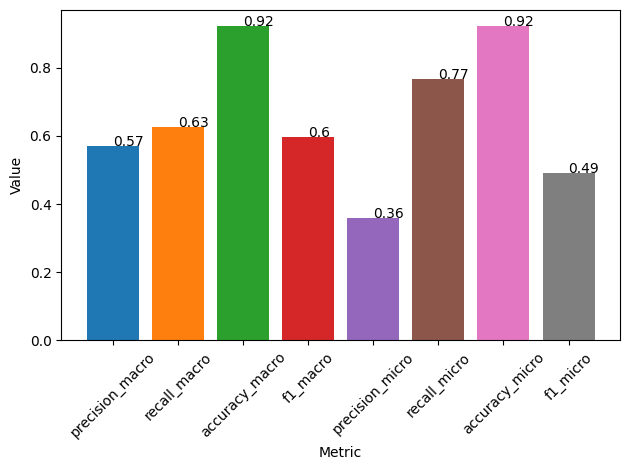

In [22]:
#plot the evaluation metrics
plt.figure()
for metric_name, metric_value in evaluation_metrics.items():
    plt.bar(metric_name, metric_value)
    plt.xticks(rotation=45)
    plt.xlabel('Metric')
    plt.ylabel('Value')
    #annotate the bar with the value
    plt.text(metric_name, metric_value, str(round(metric_value, 2)))
plt.tight_layout()
plt.savefig(f'{evaluations_save_folder}/evaluation_metrics.png')
plt.show()

In [23]:
#calculate the metrics for every test dataset
#best_thresholds = best_thresholds.cpu().numpy()
score_dict = {'data_source' : [], 'f1_micro' : [], 'f1_macro': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'accuracy_micro': [], 'accuracy_macro': []}
if os.path.exists(f'{evaluations_save_folder}/break_down_scores.json'):
    with open(f'{evaluations_save_folder}/break_down_scores.json', 'r') as f:
        score_dict = json.load(f)
else:
    for test_dataset, matching_package in zip(test_datasets, test_packages):
        y_true_single = []
        y_pred_single = []
        x_single = []
        model.to(device)
        model.eval()
        single_test_loader = DataLoader(test_dataset, batch_size=164, num_workers=num_workers)
        with torch.no_grad():
            for inputs, labels in single_test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                y_true_single.append(labels.detach().clone())
                y_pred_single.append(outputs.detach().clone())
                x_single.append(inputs.detach().clone())
        y_true_single = torch.cat(y_true_single, dim=0).cpu()
        y_pred_single = torch.cat(y_pred_single, dim=0).cpu()
        x_single = torch.cat(x_single, dim=0).cpu()
        y_pred_single_cm = torch.sigmoid(y_pred_single) > torch.Tensor(best_thresholds)
        #calculate precision, recall, accuracy and f1 score
        precision = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
        recall = multi_label_recall(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
        accuracy = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
        f1 = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='macro', threshold=best_thresholds)
        #and micro scores
        precision_micro = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
        recall_micro = multi_label_recall(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
        accuracy_micro = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
        f1_micro = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='micro', threshold=best_thresholds)
        #save the scores
        score_dict['data_source'].append(matching_package.data_source_name)
        score_dict['f1_micro'].append(f1_micro)
        score_dict['f1_macro'].append(f1)
        score_dict['precision_micro'].append(precision_micro)
        score_dict['precision_macro'].append(precision)
        score_dict['recall_micro'].append(recall_micro)
        score_dict['recall_macro'].append(recall)
        score_dict['accuracy_micro'].append(accuracy_micro)
        score_dict['accuracy_macro'].append(accuracy)

    #save the scores to a json file
    with open(f'{evaluations_save_folder}/break_down_scores.json', 'w') as f:
        json.dump(score_dict, f)


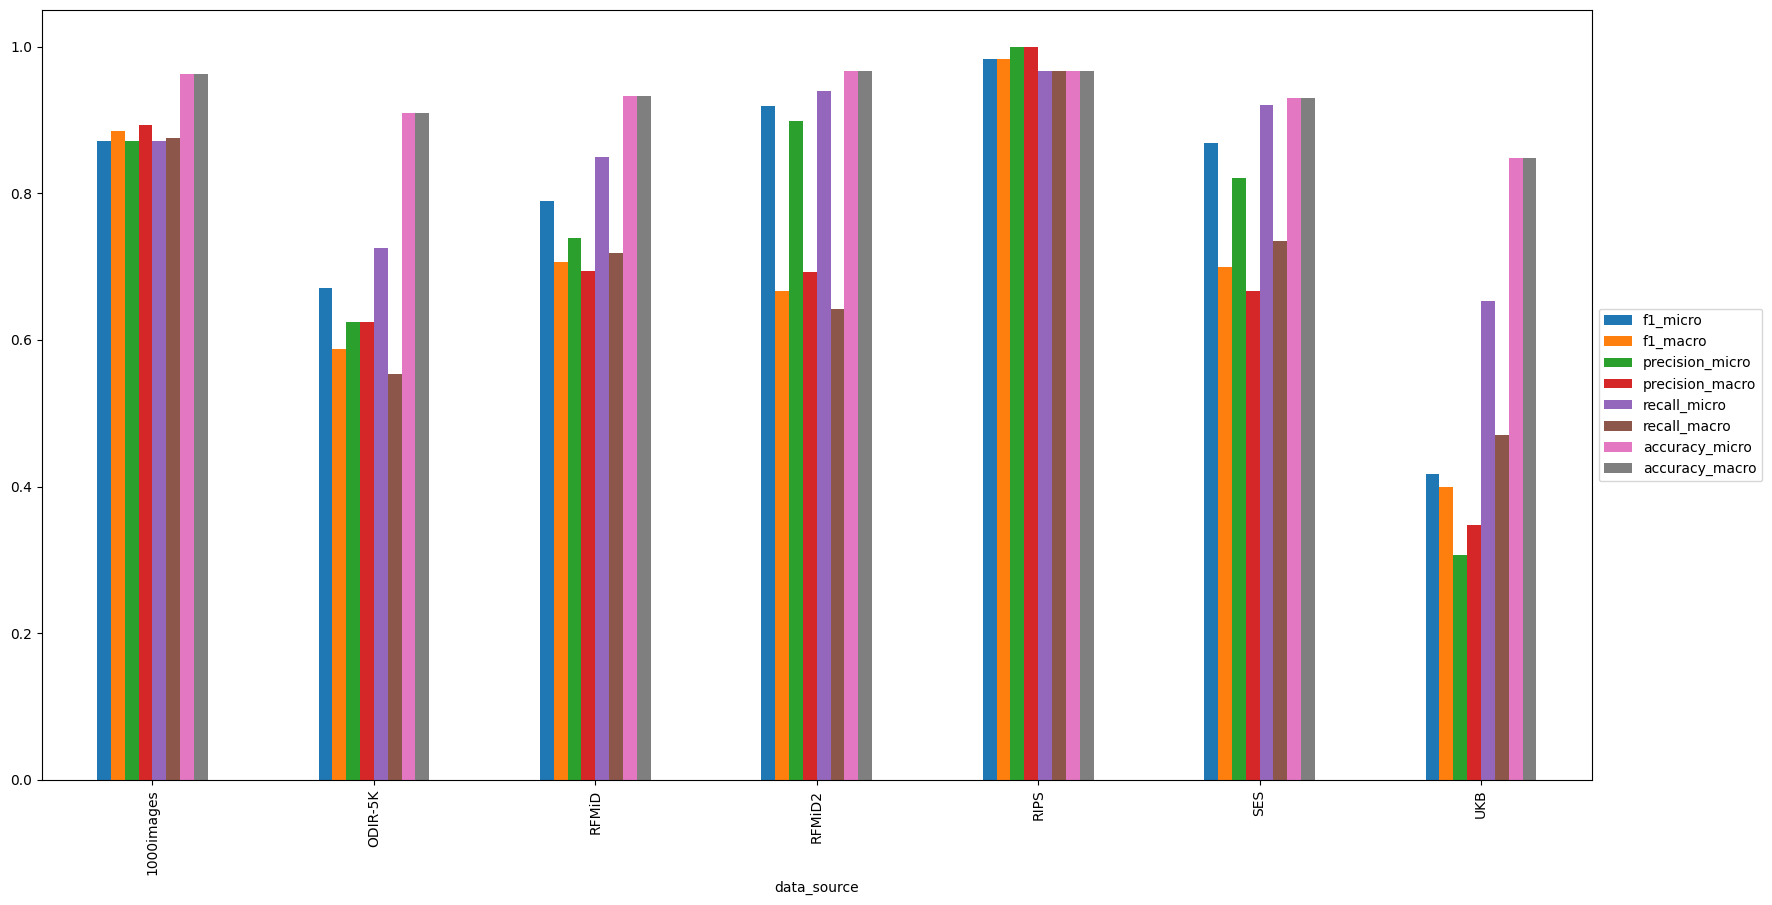

In [24]:
#create a pandas dataframe from the score dict
score_df = pd.DataFrame(score_dict)
#group the scores by data source
grouped_scores = score_df.groupby('data_source').mean()
#plot the grouped scores
grouped_scores.plot(kind='bar', figsize=(20, 10))
plt.savefig(f'{evaluations_save_folder}/grouped_scores.png')
#move the legend outside of the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [25]:
grouped_scores.round(2).head(10)

,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro,accuracy_micro,accuracy_macro
data_source,,,,,,,,
1000images,0.87,0.88,0.87,0.89,0.87,0.88,0.96,0.96
ODIR-5K,0.67,0.59,0.62,0.63,0.73,0.55,0.91,0.91
RFMiD,0.79,0.71,0.74,0.69,0.85,0.72,0.93,0.93
RFMiD2,0.92,0.67,0.90,0.69,0.94,0.64,0.97,0.97
RIPS,0.98,0.98,1.00,1.00,0.97,0.97,0.97,0.97
SES,0.87,0.70,0.82,0.67,0.92,0.73,0.93,0.93
UKB,0.42,0.40,0.31,0.35,0.65,0.47,0.85,0.85


In [26]:
score_df.head(20)

,data_source,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro,accuracy_micro,accuracy_macro
0,ODIR-5K,0.670940,0.587348,0.624254,0.625106,0.725173,0.553891,0.908983,0.908983
1,RFMiD,0.790123,0.706135,0.739030,0.694697,0.848806,0.717956,0.933097,0.933097
2,RFMiD2,0.918519,0.666220,0.898551,0.692727,0.939394,0.641667,0.966667,0.966667
3,1000images,0.870968,0.884291,0.870968,0.893250,0.870968,0.875510,0.963134,0.963134
4,RIPS,0.983051,0.983051,1.000000,1.000000,0.966667,0.966667,0.966667,0.966667
5,SES,0.867925,0.698885,0.821429,0.666667,0.920000,0.734375,0.930000,0.930000
6,UKB,0.417492,0.399839,0.306667,0.348015,0.653747,0.469798,0.847976,0.847976


In [27]:
model.to(device)
model.train()
all_dropout_predictions = []
all_dropout_labels = []
#run the model on the test set with dropout enabled, 100 times
n_predictions = 100
prediction_progress_bar = tqdm.tqdm(range(n_predictions))
for i in prediction_progress_bar:
    y_test_dropout_predictions = []
    labels_dropout = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_test_dropout_predictions.append(outputs.detach().clone())
            labels_dropout.append(labels.detach().clone())
        y_test_dropout_predictions = torch.cat(y_test_dropout_predictions, dim=0).cpu()
        all_dropout_predictions.append(y_test_dropout_predictions)
        labels_dropout = torch.cat(labels_dropout, dim=0).cpu()
        all_dropout_labels.append(labels_dropout)
all_dropout_predictions = torch.stack(all_dropout_predictions, dim=0)
all_dropout_labels = torch.stack(all_dropout_labels, dim=0)

100%|██████████| 100/100 [12:50<00:00,  7.71s/it]


In [28]:
#rearrrange the predictions so that the first dimension is the number of predictions
print(all_dropout_predictions.shape)

torch.Size([100, 1356, 21])


In [29]:
import numpy as np
from scipy.stats import entropy


# variable probs with shape [batch_size, num_classes, num_ensemble_members]
def total_uncertainty_entropy(probs, norm=False):
    t_u = entropy(np.mean(probs, axis=0), axis=0, base=2)
    if norm:
        t_u = t_u / np.log2(probs.shape[1])
    return t_u


def epistemic_uncertainty_entropy(probs, norm=False):
    mean_probs = np.mean(probs, axis=0)
    mean_probs = np.repeat(np.expand_dims(mean_probs, 2), repeats=probs.shape[2], axis=2)
    e_u = entropy(probs, mean_probs, axis=0, base=2)
    if norm:
        e_u = e_u / np.log2(probs.shape[1])
    e_u = np.mean(e_u, axis=1)
    return e_u


def aleatoric_uncertainty_entropy(probs, norm=False):
    a_u = entropy(probs, axis=0, base=2)
    if norm:
        a_u = a_u / np.log2(probs.shape[1])
    a_u = np.mean(a_u, axis=1)
    return a_u

def total_uncertainty_variance(probs):
    mean = np.mean(probs, axis=0)
    t_u = np.sum(mean * (1 - mean), axis=1)
    return t_u


def aleatoric_uncertainty_variance(probs):
    a_u = np.mean(np.sum(probs * (1 - probs), axis=1), axis=1)
    return a_u


def epistemic_uncertainty_variance(probs):
    mean = np.mean(probs, axis=2, keepdims=True)
    e_u = np.mean(np.sum(probs * (probs - mean), axis=1), axis=1)
    return e_u

In [30]:
import numpy as np
from scipy.stats import entropy

# variable probs with shape [num_ensemble_members, batch_size, num_classes]
def total_uncertainty_entropy(probs, norm=False):
    t_u = - np.log2(np.mean(probs, axis=0)) * np.mean(probs, axis=0) # Change axis to 1
    if norm:
        t_u = t_u / np.log2(probs.shape[2])
    return t_u

def epistemic_uncertainty_entropy(probs, norm=False):
    mean_probs = np.mean(probs, axis=0)
    mean_probs = np.repeat(np.expand_dims(mean_probs, 0), repeats=probs.shape[0], axis=0)
    e_u = entropy(probs, mean_probs, axis=2, base=2)  # Change axis to 2
    e_u = - np.log2(probs / np.mean(probs, axis=0)) * np.mean(probs, axis=0)
    if norm:
        e_u = e_u / np.log2(probs.shape[2])
    e_u = np.mean(e_u, axis=0)  # Change axis to 0
    return e_u

def aleatoric_uncertainty_entropy(probs, norm=False):
    a_u = - np.log2(probs) * probs  # Change axis to 2
    if norm:
        a_u = a_u / np.log2(probs.shape[2])
    a_u = np.mean(a_u, axis=0)  # Change axis to 0
    return a_u

def total_uncertainty_variance(probs):
    mean = np.mean(probs, axis=0)
    t_u = np.sum(mean * (1 - mean), axis=1)  # Change axis to 1
    return t_u

def aleatoric_uncertainty_variance(probs):
    a_u = np.mean(np.sum(probs * (1 - probs), axis=2), axis=0)  # Change axis to 2, then to 0
    return a_u

def epistemic_uncertainty_variance(probs):
    mean = np.mean(probs, axis=0, keepdims=True)
    e_u = np.mean(np.sum(probs * (probs - mean), axis=2), axis=0)  # Change axis to 2, then to 0
    return e_u


In [31]:
#calculate the entopy uncertainty, aleatoric and epistemic uncertainty
all_dropout_predictions_probs = torch.sigmoid(all_dropout_predictions)
all_dropout_predictions_numpy = all_dropout_predictions_probs.numpy()
entropy_uncertainty = total_uncertainty_entropy(all_dropout_predictions_numpy)
aleatoric_uncertainty = aleatoric_uncertainty_entropy(all_dropout_predictions_numpy)
epistemic_uncertainty = epistemic_uncertainty_entropy(all_dropout_predictions_numpy)
#total uncertainty entropy
total_uncertainity_entropy = total_uncertainty_entropy(all_dropout_predictions_numpy)


In [32]:
print('Entropy uncertainty:', entropy_uncertainty.shape)
print('Epistemic uncertainty:', epistemic_uncertainty.shape)
print('Aleatoric uncertainty:', aleatoric_uncertainty.shape)

Entropy uncertainty: (1356, 21)
Epistemic uncertainty: (1356, 21)
Aleatoric uncertainty: (1356, 21)


In [33]:
import scienceplots
plt.style.use(['science', 'no-latex'])

In [34]:
print('Entroapy uncertainty:', aleatoric_uncertainty.shape)

Entroapy uncertainty: (1356, 21)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def plot_f1_rejection_curve(pred, labels, uncertainties, multi_label_f_beta = multi_label_f_beta, best_thresholds = best_thresholds, evaluations_save_folder = evaluations_save_folder, uncertainity_type = None, save = False):
    plt.figure(figsize=(10, 6))
    plt.title('F1 Score Rejection Curve')
    plt.xlabel('Rejection Rate')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('F1 Score')
    plt.grid(True)
    for j in range(len(labels_to_encode)):
        # Ensure inputs are numpy arrays
        uncertainties_class = np.array(uncertainties[:, j])

        #mean the predictions
        pred_mean = torch.mean(pred, axis=0)
        labels_mean = torch.mean(labels, axis=0)
        
        #get the sorted indices
        sorted_indices = np.argsort(uncertainties_class)
        #flip the indices
        #sorted_indices = np.flip(sorted_indices, axis=-1).copy()
        preds_sorted = pred_mean[sorted_indices]
        labels_sorted = labels_mean[sorted_indices]
        f1_scores = []
        rejection_rates = []

        for i in range(len(pred), 1, -1):
            retained_pred = preds_sorted[:i]
            retained_labels = labels_sorted[:i]
            
            
            f1 = f1_score(retained_labels, retained_pred.numpy() > best_thresholds, average='micro', zero_division=0)
            f1_scores.append(f1)
            rejection_rates.append(1 - i / len(pred))

        
        plt.plot(rejection_rates, f1_scores, label=labels_to_encode[j])
        
        
        if save:
            plt.savefig(f'{evaluations_save_folder}/f1_rejection_curve_{uncertainity_type}.png')
    plt.legend(loc='upper right')
    plt.show()


In [36]:
print(aleatoric_uncertainty)

[[0.01378002 0.00193538 0.0015787  ... 0.00318963 0.00499752 0.00305785]
 [0.06801042 0.02759186 0.00689191 ... 0.00902119 0.01037703 0.00632939]
 [0.0269329  0.00731173 0.0052564  ... 0.00762679 0.00928071 0.00586077]
 ...
 [0.0303631  0.07441958 0.00485351 ... 0.00420008 0.0087866  0.00777162]
 [0.04592669 0.01084025 0.00294178 ... 0.00623779 0.01083319 0.00314308]
 [0.01942443 0.00861836 0.00419621 ... 0.0058753  0.00643656 0.00711591]]


In [37]:
#print shape of the predictions and labels
print(all_dropout_predictions.shape)
print(all_dropout_labels.shape)
print(entropy_uncertainty.shape)

torch.Size([100, 1356, 21])
torch.Size([100, 1356, 21])
(1356, 21)


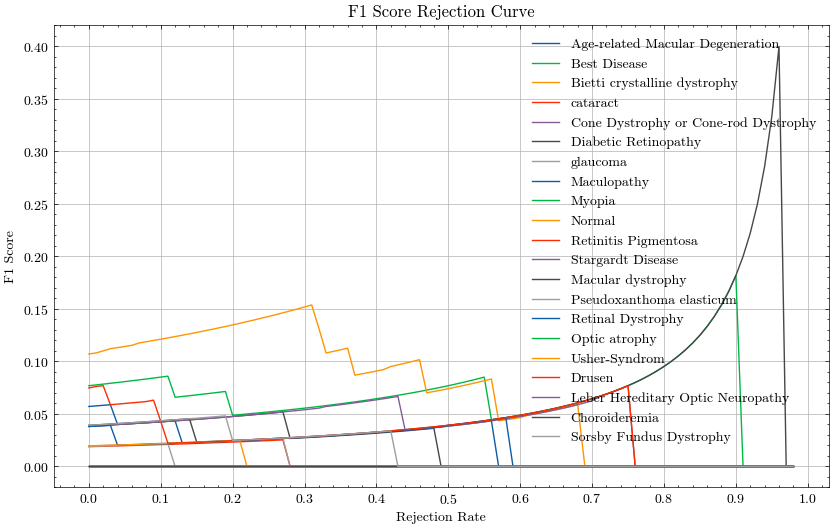

In [38]:
#create a rejection curve for the aleatoric uncertainty
all_dropout_labels_numpy = all_dropout_labels.numpy()
#best_thresholds_np = best_thresholds.numpy()
plot_f1_rejection_curve(all_dropout_predictions, all_dropout_labels, aleatoric_uncertainty, uncertainity_type='aleatoric', best_thresholds=best_thresholds)


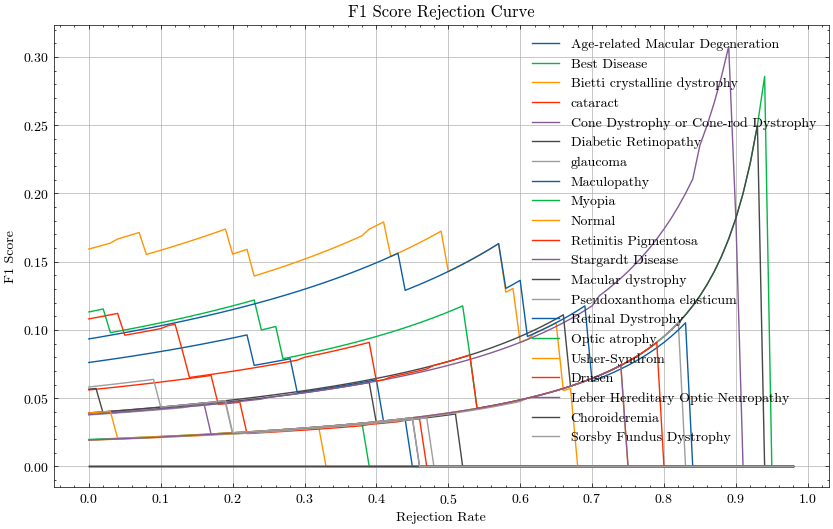

In [39]:
plot_f1_rejection_curve(all_dropout_predictions, all_dropout_labels, epistemic_uncertainty, uncertainity_type='epistemic')

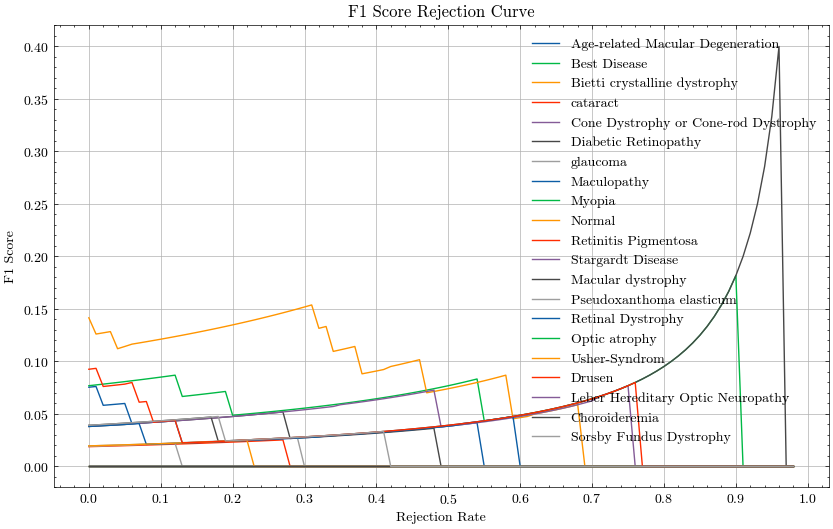

In [40]:
plot_f1_rejection_curve(all_dropout_predictions, all_dropout_labels, total_uncertainity_entropy, uncertainity_type='totaL')

Text(0, 0.5, 'Epistemic Uncertainty')

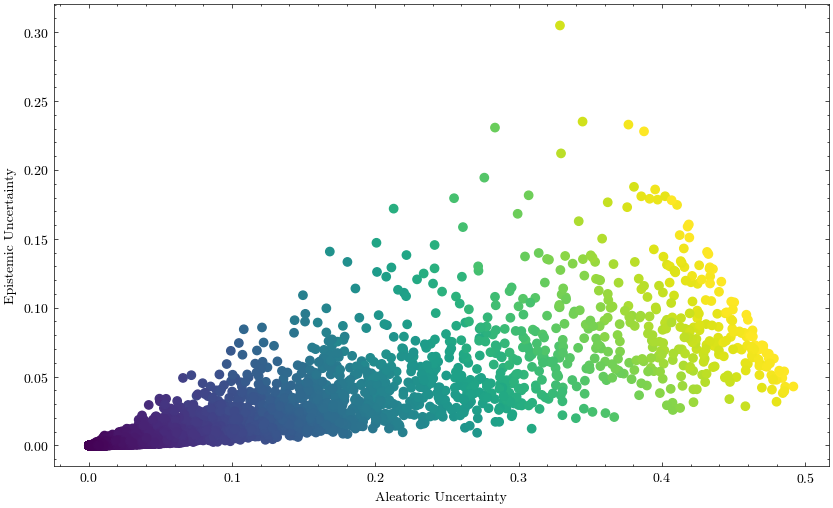

In [41]:
#scatter plot the aleatoric and epistemic uncertainty
plt.figure(figsize=(10, 6))
plt.scatter(aleatoric_uncertainty, epistemic_uncertainty, c=entropy_uncertainty)
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Epistemic Uncertainty')


Max entropy: 21.0


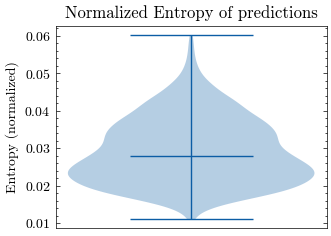

In [42]:
total_u_s = np.sum(total_uncertainity_entropy, axis=1)
max_entropy = -np.log2(0.5)*len(labels_to_encode)
entropy_normalized = total_u_s / max_entropy
print(f'Max entropy: {max_entropy}')
#plot the entropy
fig, ax = plt.subplots()
ax.violinplot(entropy_normalized, showmedians=True, points=500)
ax.set_title('Normalized Entropy of predictions')
#turn off the x axis
ax.set_xticks([])
ax.set_ylabel('Entropy (normalized)')
#ylim
#add ytick at the median entropy
plt.show()

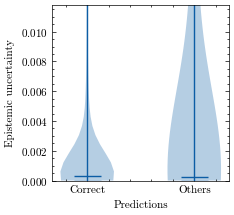

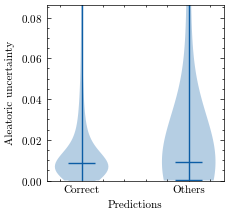

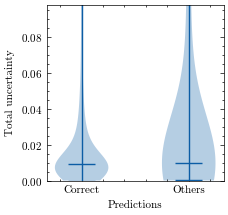

In [79]:
#mean the dropout predictions
mean_dropout_predictions = torch.mean(all_dropout_predictions, axis=0)
mean_dropout_predictions_probs = torch.sigmoid(mean_dropout_predictions)
mean_dropout_predictions_numpy = mean_dropout_predictions_probs.numpy()
#mean the labels
mean_labels_numpy = torch.mean(all_dropout_labels, axis=0).numpy()
#find the total correct predictions
correct_prediction_indicator = (mean_dropout_predictions_numpy > best_thresholds) == mean_labels_numpy
#get the total correct predictions
totally_corrcet = correct_prediction_indicator.all(axis=1)
not_totally_correct = ~totally_corrcet
epistemic_correct = epistemic_uncertainty[correct_prediction_indicator]
aleatoric_correct = aleatoric_uncertainty[correct_prediction_indicator]
total_correct = total_uncertainity_entropy[correct_prediction_indicator]
epistemic_incorrect = epistemic_uncertainty[~correct_prediction_indicator]
aleatoric_incorrect = aleatoric_uncertainty[~correct_prediction_indicator]
total_incorrect = total_uncertainity_entropy[~correct_prediction_indicator]
#create a plot for each type of uncertainty
for uncertainty, title in zip([[epistemic_correct, epistemic_incorrect], [aleatoric_correct, aleatoric_incorrect], [total_correct, total_incorrect]], ['Epistemic', 'Aleatoric', 'Total']):
    fig, ax = plt.subplots(figsize=(4.8/2 *0.95, 4.8/2 *0.95))
    uncertainty_correct, uncertainty_incorrect = uncertainty
    #violon plot the correct and incorrect predictions
    ax.violinplot([uncertainty_correct, uncertainty_incorrect], showmedians=True, points=500)
    #exclude outliers everythign above 1.5 times the interquartile range
    iqr = np.percentile(uncertainty_correct, 95)
    #filter out the outliers
    ax.set_xticks([1, 2])
    ax.set_xlabel('Predictions', fontsize=8)
    ax.set_ylabel(f'{title} uncertainty', fontsize=8)
    ax.set_ylim(0, iqr)
    ax.set_xticklabels(['Correct', 'Others'], fontsize=8)
    #set the fontsize of the yticks
    ax.tick_params(axis='y', labelsize=8)
    #rotate the xticks
    plt.xticks(rotation=0)
    #save the figure
    plt.savefig(f'{evaluations_save_folder}/{title}_uncertainty.pdf')
    plt.show()
# #plot the correct and incorrect predictions
# fig, ax = plt.subplots()
# #violon plot the correct and incorrect predictions
# ax.violinplot([aleatoric_correct, aleatoric_incorrect], showmedians=True, points=500)
# #exclude outliers everythign above 1.5 times the interquartile range
# iqr = np.percentile(aleatoric_correct, 95)
# #filter out the outliers
# ax.set_xticks([1, 2])
# ax.set_xlabel('Predictions')
# ax.set_ylabel(f'Uncertainty')
# ax.set_ylim(0, iqr)
# ax.set_xticklabels(['Totally Correct', 'Not Totally Correct'])
# plt.show()

In [50]:
print(uncertainty_correct.shape)

(25803,)


In [78]:
#get the 0.9 percentile of the aleatoric episemic
percentile_90 = np.percentile(epistemic_incorrect, 75)
print(f'90th percentile of epistemic incorrect uncertainty: {percentile_90}')
#check which precentile this is for the aleatoric uncertainty
percentile_90 = np.percentile(epistemic_correct, 90)
print(f'90th percentile of epistemic correct uncertainty: {percentile_90}')

90th percentile of epistemic incorrect uncertainty: 0.007094418630003929
90th percentile of epistemic correct uncertainty: 0.004822765849530694


AxisError: axis 1 is out of bounds for array of dimension 1

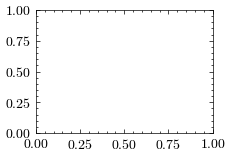

In [49]:
for uncertainty, title in zip([[epistemic_correct, epistemic_incorrect], [aleatoric_correct, aleatoric_incorrect], [total_correct, total_incorrect]], ['Epistemic', 'Aleatoric', 'Total']):
    fig, ax = plt.subplots(figsize=(4.8/2 *0.95, 4.8/3))
    uncertainty_correct, uncertainty_incorrect = uncertainty
    #violon plot the correct and incorrect predictions
    ax.violinplot([uncertainty_correct.sum(axis = 1), uncertainty_incorrect.sum(axis = 1)], showmedians=True, points=500)
    #exclude outliers everythign above 1.5 times the interquartile range
    iqr = np.percentile(uncertainty_correct, 95)
    #filter out the outliers
    ax.set_xticks([1, 2])
    ax.set_xlabel('Predictions', fontsize=8)
    ax.set_ylabel(f'{title} uncertainty', fontsize=8)
    ax.set_ylim(0, iqr)
    ax.set_xticklabels(['Correct', 'Others'], fontsize=8)
    #set the fontsize of the yticks
    ax.tick_params(axis='y', labelsize=8)
    #rotate the xticks
    plt.xticks(rotation=0)
    #save the figure
    #plt.savefig(f'{evaluations_save_folder}/{title}_uncertainty.pdf')
    plt.show()

In [44]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
#get all the X_test images that were predicted as Retinitis Pigmentosa
#get the index of Retinitis Pigmentosa
rp_index = labels_to_encode.index('Retinitis Pigmentosa')
#find the indices of the Retinitis Pigmentosa predictions
rp_indices = mean_labels_numpy[:, rp_index].astype(bool)
#find the images that were predicted as Retinitis Pigmentosa
rp_images = X_test[rp_indices]
#find the tp, fp, tn, fn for the Retinitis Pigmentosa predictions
rp_labels = y_true.clone().detach().numpy().astype(bool)[:, rp_index]
rp_predictions = y_pred_cm.clone().detach().numpy().astype(bool)[:, rp_index]
rp_tp = rp_labels & rp_predictions
rp_fp = ~rp_labels & rp_predictions
rp_tn = ~rp_labels & ~rp_predictions
rp_fn = rp_labels & ~rp_predictions

In [46]:
#print the number of tp, fp, tn, fn
print(f'TP: {rp_tp.sum()}')
print(f'FP: {rp_fp.sum()}')
print(f'TN: {rp_tn.sum()}')
print(f'FN: {rp_fn.sum()}')

TP: 193
FP: 56
TN: 1098
FN: 9


In [47]:
import captum

#use the gradcam algorithm to visualise the predictions
from captum.attr import LayerGradCam, LayerAttribution, GuidedGradCam
from captum.attr import visualization as viz
attributions = []
numpy_converted_images = []
model.eval()
guided_gc = GuidedGradCam(model, model.layer4)

selected_image_tp = X_test[rp_tp][108].clone().detach().unsqueeze(0) #index 50 is image with date
selected_image_fp = X_test[rp_fp][-5].clone().detach().unsqueeze(0)
selected_image_tn = X_test[rp_tn][-10].clone().detach().unsqueeze(0)
selected_image_fn = X_test[rp_fn][6].clone().detach().unsqueeze(0)
print(selected_image_tp.shape)
selected_images = [selected_image_tp, selected_image_fp, selected_image_fn, selected_image_tn]
#calculate the attributions for the selected images
for selected_image in selected_images:
    selected_image.requires_grad = True
    numpy_converted_images.append(selected_image[0].detach().clone().permute(1,2,0).numpy())

torch.Size([1, 3, 224, 224])


torch.Size([1, 21])


/tmp/ipykernel_91513/1122619722.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(selected_images[i]).to(device)


torch.Size([1, 21])
torch.Size([1, 21])
torch.Size([1, 21])


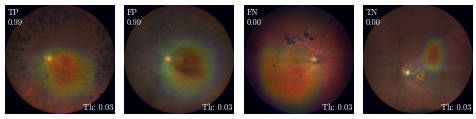

In [48]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image	
#set requires_grad to True for all layers
model.eval()
model.to(device)
cm_indicator = ['TP', 'FP', 'FN', 'TN']
cam_extractor = GradCAM(model, target_layer=model.layer4)
fig, axes = plt.subplots(1, 4, figsize=(4.8, 3))
for i in range(len(selected_images)):
    # Compute CAM

    img_tensor = torch.tensor(selected_images[i]).to(device)
    out = model(img_tensor)
    pred = out.squeeze(0).argmax().item()
    pred = torch.tensor(pred).to(device).item()
    print(out.shape)
    prob = torch.sigmoid(out)[0,rp_index]
    cam = cam_extractor(pred, out)
    overlay = overlay_mask(to_pil_image(img_tensor[0]), to_pil_image(cam[0].squeeze(0).permute(1, 0), mode='F'), alpha=0.9)
    # Plotting CAM overlay
    axes[i].imshow(overlay)
    axes[i].axis('off')
    #annotate with TP, FP, TN, FN
    axes[i].text(5, 20, cm_indicator[i], fontsize=6, color='white')
    axes[i].text(5, 40, f"{(prob.item()):.2f}", fontsize=6, color='white')
    axes[i].text(160, 215, f'Th: {(best_thresholds[rp_index]):.2f}', fontsize=6, color='white')

plt.tight_layout(pad=0.2)
plt.savefig(f'{evaluations_save_folder}/gradcam.pdf')
plt.show()